In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from collections import Counter
import optuna
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from functools import partial

sns.set()

In [3]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [4]:
raw_data = pd.read_csv('dataset.csv')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [5]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [6]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)
data.index = pd.to_datetime(data.index)  # Convert index to DateTimeIndex if not already


In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [8]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [9]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [10]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [11]:
df_train = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2010-07-01']
train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret',
                                    ],axis=1)
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
y_train = df_train['rel_performance'].values
y_valid = df_valid['rel_performance'].values

# Here we set Maximum Drawdown as the target 

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def objective(trial, train=None, labels=None, val=None, val_labels=None, val_rets=None):
    ada_m_depth = trial.suggest_int('max_depth', 1, 3, step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
    ada_learning_rate = trial.suggest_float('learning_rate', 0.1, 0.5, step=0.1)
    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train, labels)
    preds = ada_clf.predict(val)
    
    # Assume each prediction directly influences a return in val_rets; adjust logic as necessary
    # For simplicity, let's assume positive predictions mean a positive return and vice versa
    # This part needs to be adjusted based on how predictions affect returns in your specific case
    cumulative_returns = np.cumprod(1 + val_rets * preds)  # This is a simplified example
    drawdowns = 1 - (cumulative_returns / np.maximum.accumulate(cumulative_returns))
    max_drawdown = np.max(drawdowns)
    
    # Since we want to minimize the objective, we return the maximum drawdown directly
    return max_drawdown


In [13]:
import _pickle as cPickle
import pickle

## We build our classifier based on the training period 2001-01-01 to 2004-01-01

In [14]:
study = optuna.create_study(direction="minimize")
    
# Optimize the study, partial is used to pass additional arguments to the objective function
study.optimize(partial(objective,
                       train=train,
                       labels=y_train,
                       val=valid,
                       val_labels=y_valid,
                       val_rets=valid_stock_returns),
               n_trials=25, n_jobs=-1)


# Print the best parameters for the current iteration
print(study.best_params)

{'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.4}


In [15]:
max_depth = study.best_params['max_depth']
n_estimators = study.best_params['n_estimators']
learning_rate = study.best_params['learning_rate']
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),n_estimators=n_estimators,learning_rate=learning_rate)

# Now we test the classifier for different features set 

In [16]:
def compute_max_drawdown(cumulative_returns):
    """
    Computes the maximum drawdown from a series of cumulative returns.

    Parameters:
    - cumulative_returns: A Pandas Series or DataFrame column with cumulative returns.

    Returns:
    - max_drawdown: The maximum drawdown expressed as a positive percentage.
    """
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate the drawdowns as the difference between the running max and the current value
    drawdowns = (cumulative_returns - running_max) / running_max
    # Find the minimum drawdown; since drawdowns are negative, the minimum is the maximum drawdown
    max_drawdown = drawdowns.min()
    # Return the maximum drawdown as a positive value
    return abs(max_drawdown)

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086


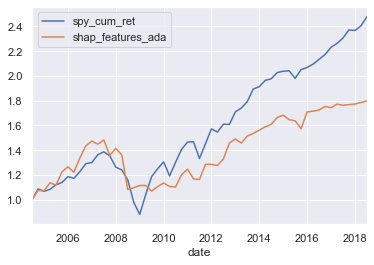

In [17]:
with open(r'shap_features_ada.pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)
SPY = pd.read_pickle('SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['shap_features_ada'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086
shap_features_ada_01,0.108142


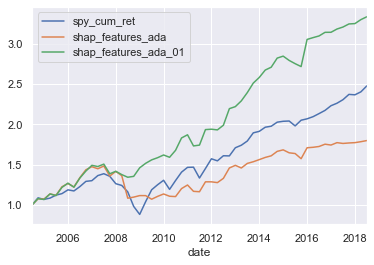

In [18]:
with open(r'shap_features_ada_01.pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)
SPY['shap_features_ada_01'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086
shap_features_ada_01,0.108142
shap_features_ada_02,0.086352


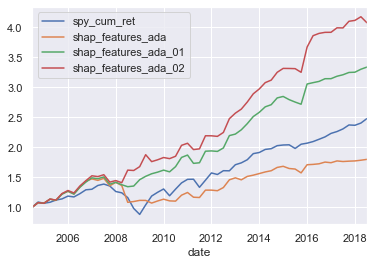

In [19]:
with open(r'shap_features_ada_02 (1).pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

SPY['shap_features_ada_02'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

# Now we change the objective to accuracy and experiment on different sets

In [20]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy


In [21]:
study = optuna.create_study(direction="maximize")
    
# Optimize the study, partial is used to pass additional arguments to the objective function
study.optimize(partial(objective,
                       train=train,
                       labels=y_train,
                       val=valid,
                       val_labels=y_valid,
                       val_rets=valid_stock_returns),
               n_trials=50, n_jobs=-1)


# Print the best parameters for the current iteration
print(study.best_params)

{'max_depth': 1, 'n_estimators': 20, 'learning_rate': 0.5}


In [22]:
max_depth = study.best_params['max_depth']
n_estimators = study.best_params['n_estimators']
learning_rate = study.best_params['learning_rate']
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),n_estimators=n_estimators,learning_rate=learning_rate)

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086
shap_features_ada_01,0.108142
shap_features_ada_02,0.086352
acc_shap_features_ada,0.286546


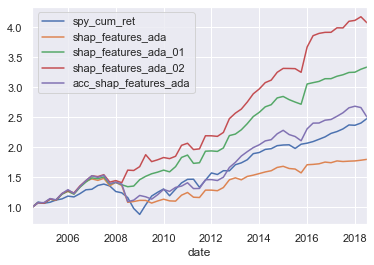

In [24]:
with open(r'shap_features_ada.pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

SPY['acc_shap_features_ada'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086
shap_features_ada_01,0.108142
shap_features_ada_02,0.086352
acc_shap_features_ada,0.286546
acc_shap_features_ada_02,0.147707
acc_shap_features_ada_01,0.090973


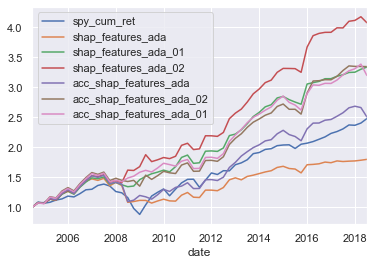

In [26]:
with open(r'shap_features_ada_01.pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

SPY['acc_shap_features_ada_01'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

,Maximum Drawdown
spy_cum_ret,0.364379
shap_features_ada,0.278086
shap_features_ada_01,0.108142
shap_features_ada_02,0.086352
acc_shap_features_ada,0.286546
acc_shap_features_ada_02,0.147707
acc_shap_features_ada_01,0.090973


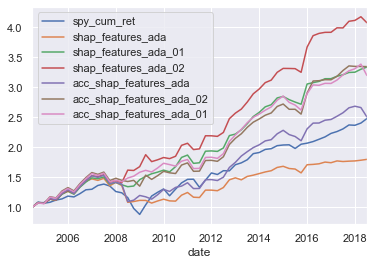

In [27]:
with open(r'shap_features_ada_02 (1).pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

SPY['acc_shap_features_ada_02'] = x
SPY.plot();
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

# Now we define new labels 

### We adjust the label using the rolling volatility of each firm, penalize the label being one for high volatility and thus leading to less maximum drawdown within the portfolio

In [30]:
# Calculate the volatility (standard deviation) for the past N quarters

data['volatility'] = data.groupby('ticker')['return'].transform(lambda x: x.rolling(window=4).std())
data['volatility'].fillna(1,inplace=True)
data['risk_adjusted_return'] = data['pred_rel_return'] / data['volatility']
data['risk_adjusted_return'].fillna(0,inplace=True)
def risk_adjusted_strategy(row, threshold=0.10):
    if row['risk_adjusted_return'] > threshold:
        return 1  # Buy
    elif row['risk_adjusted_return'] < -threshold:
        return -1  # Sell
    else:
        return 0  # Hold

data['sma_signal'] = data.apply(risk_adjusted_strategy, axis=1)


In [32]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]
training_labels = [d['sma_signal'].values for d in training_frames]
valid_labels = [d['sma_signal'].values for d in valid_frames] 
df_train = data.loc['2001-01-01':'2004-01-01']
df_valid = data.loc['2004-04-01':'2010-07-01']
train = df_train.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret','risk_adjusted_return','volatility','sma_signal'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret','risk_adjusted_return','volatility','sma_signal'
                                    ],axis=1)
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
y_train = df_train['sma_signal'].values
y_valid = df_valid['sma_signal'].values

In [33]:
study = optuna.create_study(direction="maximize")
    
# Optimize the study, partial is used to pass additional arguments to the objective function
study.optimize(partial(objective,
                       train=train,
                       labels=y_train,
                       val=valid,
                       val_labels=y_valid,
                       val_rets=valid_stock_returns),
               n_trials=50, n_jobs=-1)


# Print the best parameters for the current iteration
print(study.best_params)

{'max_depth': 1, 'n_estimators': 100, 'learning_rate': 0.2}


In [34]:
max_depth = study.best_params['max_depth']
n_estimators = study.best_params['n_estimators']
learning_rate = study.best_params['learning_rate']
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),n_estimators=n_estimators,learning_rate=learning_rate)

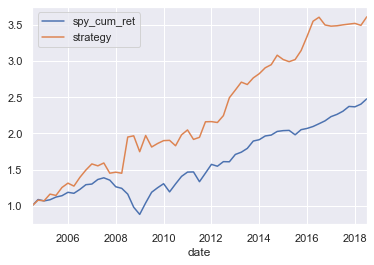

In [35]:
with open(r'shap_features_ada_02 (1).pkl','rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(valid_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        ada_clf.fit(opt_training_data[i],training_labels[i])

        preds = ada_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)
SPY = pd.read_pickle('SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

In [36]:
strategy_mean_ret = (SPY - 1).diff().mean()
strategy_std = (SPY - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('SPY Ratio: ',strategy_sr[0])
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

SPY Ratio:  0.39248309920617996
Strategy Sharpe Ratio:  0.4119378485348729


## We diversity our portfolio with SPY to improve the Sharpe ratio 

In [100]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [101]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.2390710398279866

In [37]:
SPY['Diversified'] = 0.5*SPY['strategy'] + 0.5*(SPY['spy_cum_ret']) 

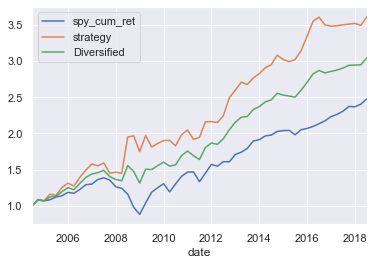

In [38]:
SPY.plot();

In [42]:
strategy_mean_ret = (SPY['Diversified'] - 1).diff().mean()
strategy_std = (SPY['Diversified'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Diversified Strategy Sharpe Ratio: ',strategy_sr)

Diversified Strategy Sharpe Ratio:  0.5269941371215014


In [41]:
max_drawdown = compute_max_drawdown(SPY)
max_drawdown_df = pd.DataFrame(max_drawdown, columns=['Maximum Drawdown'])
max_drawdown_df

,Maximum Drawdown
spy_cum_ret,0.364379
strategy,0.111568
Diversified,0.155136
